# Investing using graph theory


In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.linalg import expm
from sklearn.covariance import LedoitWolf
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm

## Step 1: Get Official Holdings

In [2]:
def list_spy_holdings() -> pd.DataFrame:
    # Source: https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-500-etf-trust-spy
    url = 'https://www.ssga.com/us/en/intermediary/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'

    # Read the excel file directly from the URL
    # Requires 'openpyxl'
    return pd.read_excel(url, engine='openpyxl', index_col='Ticker', skiprows=4).dropna()

print("Fetching official S&P 500 holdings from SSGA...")

try:
    spy_holdings = list_spy_holdings()

    # Convert index to list and filter out 'CASH_USD' or other non-equity placeholders
    tickers = [t for t in spy_holdings.index.tolist() if isinstance(t, str) and "-" not in t]

    # YFinance expects hyphens for classes (e.g., BRK-B) instead of dots (BRK.B)
    tickers = [t.replace('.', '-') for t in tickers]

    print(f"Successfully retrieved {len(tickers)} tickers.")
    dataset_name = "S&P 500 Network - Top 100 Correlations"

except:
    print(f"Error fetching S&P 500 holdings. Using sample set.")
    # Fallback to top tech stocks if fetch fails
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
    dataset_name = "Magnificent 7 Network"

Fetching official S&P 500 holdings from SSGA...
Successfully retrieved 503 tickers.


## Step 2: Data Download and Processing

Based on https://doi.org/10.1007/s41109-020-0251-z [1]. Personally, I disagree with their methodology:

*   Using today's S&P 500 list to simulate 20 years of history introduces Survivorship Bias because you are effectively predicting the future: you are only including companies that were robust enough to survive until the present day. Using backward fill for data missing at the start is also cheating. It assumes you knew the price of a stock before it started trading. The fix is to build a new graph for every window based only on the S&P 500 constituents at the time. I haven't done this yet because it is extraordinarily painful to find a complete list of historical S&P companies without paying.
*   "Since **financial data is non stationary** we use a window of **300 days** and slide along this 30 days at a time to obtain a sample where **we can assume the data is stationary**, giving us 140 windows overall." Bruh



In [3]:
# Download adjusted close prices
data = yf.download(tickers, start="2016-01-01", end="2026-01-05", auto_adjust=True, progress=False)['Close']

# Drop columns (tickers) with more than 10% missing data
data = data.dropna(axis=1, thresh=int(data.shape[0] * 0.9))

# Fill remaining gaps (ffill with price from previous day, then bfill from first day traded if missing from start)
data = data.ffill().bfill()

log_returns = np.log(data / data.shift(1))
log_returns = log_returns.replace([np.inf, -np.inf], np.nan)
log_returns = log_returns.dropna()

window_size = 300
step_size = 30
normalized_windows = []
network_matrices = []

# Calculate total number of rows to loop through
n_samples = log_returns.shape[0]

print(f"Starting sliding window analysis on {n_samples} days of data...")

# Loop: Start at 0, stop before we run out of data, step by 30
for i in range(0, n_samples - window_size + 1, step_size):

    # Get rows i to i+300
    window_data = log_returns.iloc[i : i + window_size]
    window_mean = window_data.mean()
    window_std = window_data.std()

    # Handle division by zero (if a stock was flat for 300 days)
    # Replace 0 std with 1 to keep value as 0 (Mean) instead of NaN
    window_std = window_std.replace(0, 1)

    # Z-Score Normalization
    normalized_window = (window_data - window_mean) / window_std

    # Ledoit-Wolf Shrinkage
    lw = LedoitWolf()
    lw.fit(normalized_window)

    # The 'covariance_' attribute is the shrunk covariance matrix
    shrunk_cov = lw.covariance_

    # The 'precision_' attribute is the inverse (for partial correlation)
    shrunk_prec = lw.precision_

    # Calculate Standard Pearson Correlation
    pearson_corr = window_data.corr()

    # Convert Covariance to Correlation
    # C_ij = Sigma_ij / sqrt(Sigma_ii * Sigma_jj)
    d_cov = np.diag(shrunk_cov)
    denom_cov = np.sqrt(np.outer(d_cov, d_cov))
    shrunk_corr = shrunk_cov / denom_cov

    # Convert Precision to Partial Correlation
    # rho_ij = - p_ij / sqrt(p_ii * p_jj)
    d_prec = np.diag(shrunk_prec)
    denom_prec = np.sqrt(np.outer(d_prec, d_prec))
    partial_corr = -shrunk_prec / denom_prec
    np.fill_diagonal(partial_corr, 1.0)

    # Store Results
    window_tickers = window_data.columns
    res = {
        "start_date": window_data.index[0],
        "end_date": window_data.index[-1],
        "covariance": pd.DataFrame(shrunk_cov, index=window_tickers, columns=window_tickers),
        "pearson_corr": pd.DataFrame(pearson_corr, index=window_tickers, columns=window_tickers),
        "shrunk_corr": pd.DataFrame(shrunk_corr, index=window_tickers, columns=window_tickers),
        "partial_corr": pd.DataFrame(partial_corr, index=window_tickers, columns=window_tickers),
        "shrinkage_coeff": lw.shrinkage_
    }
    network_matrices.append(res)

print(f"Processed {len(network_matrices)} windows.")
print(f"Last Window Shrinkage Coefficient: {network_matrices[-1]['shrinkage_coeff']:.4f}")

Starting sliding window analysis on 2514 days of data...
Processed 74 windows.
Last Window Shrinkage Coefficient: 0.0954


## Step 2.1: Data Download and Processing (My Turn)

Pearson correlation has several problems, see https://doi.org/10.1017/CBO9780511615337.008 [2]. A fix for this is to instead implement distance correlation or mutual information, or include tail dependence (https://www.finance-tutoring.fr/the-difference-between-correlation-and-tail-dependence-in-simple-terms/). However, these two new measures run into the same problem that [1] attempted to solve using partial correlation. For distance correlation, this issue can be solved using partial distance correlation. Likewise, to solve this issue for mutual information, we implement an algorithm using conditional mutual information based on https://sci-hub.se/10.1103/PhysRevLett.99.204101 [3].

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm

def calculate_mi_matrix(df_returns):
    """
    Calculates the Mutual Information matrix for a dataframe of returns.
    Returns a symmetric adjacency matrix A where A_ij = MI(stock_i, stock_j).
    """
    n_stocks = df_returns.shape[1]
    mi_matrix = np.zeros((n_stocks, n_stocks))
    columns = df_returns.columns

    # We loop through each stock and calculate its MI with all others
    # SKLearn computes MI between one target (y) and many features (X) efficiently
    print("Calculating Mutual Information Graph...")
    for i in tqdm(range(n_stocks), leave=False):
        y = df_returns.iloc[:, i].values  # Target Stock
        X = df_returns.values             # All Stocks

        # discrete_features=False tells it these are continuous numbers (returns)
        # n_neighbors=3 is the standard Kraskov parameter
        mi_scores = mutual_info_regression(X, y, discrete_features=False, n_neighbors=3)

        mi_matrix[i, :] = mi_scores

    # Symmetrize (MI(X,Y) should equal MI(Y,X), but numerical noise happens)
    mi_matrix = (mi_matrix + mi_matrix.T) / 2

    # Normalize (Optional but recommended for Diffusion)
    # Divide by diagonal (Entropy) to make it like correlation (0 to 1)
    # A_ij = MI_ij / sqrt(MI_ii * MI_jj) is a common metric ("Normalized MI")
    diag = np.diag(mi_matrix)
    denom = np.sqrt(np.outer(diag, diag))
    # Add small epsilon to avoid division by zero
    mi_normalized = mi_matrix / (denom + 1e-10)

    return pd.DataFrame(mi_normalized, index=columns, columns=columns)

# --- Usage inside your Loop ---
# Replace the Ledoit-Wolf / Correlation block with this:

# mi_adj_matrix = calculate_mi_matrix(window_data)
# (Then pass mi_adj_matrix into your diffusion function)

## Step 3: Network Visualization

Plotting networks for window: 2016-01-05 to 2017-03-14


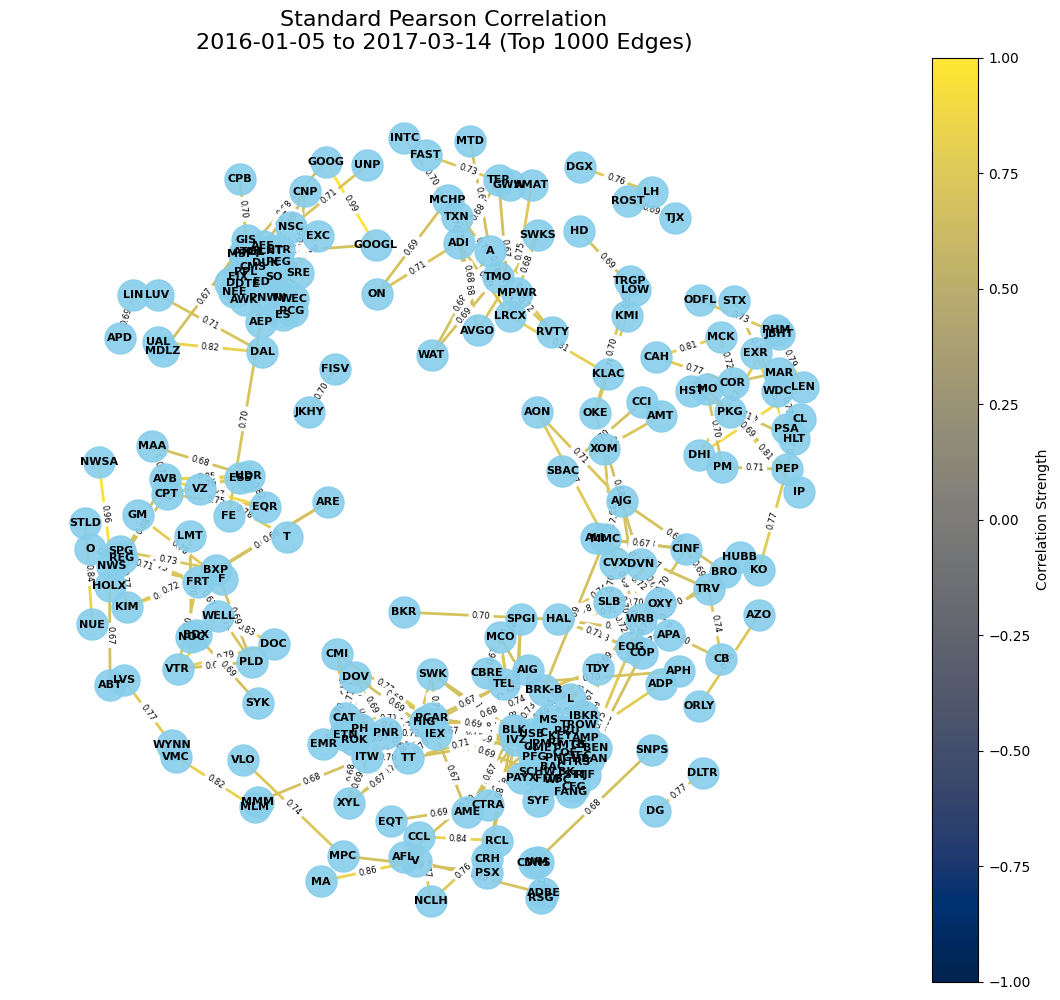

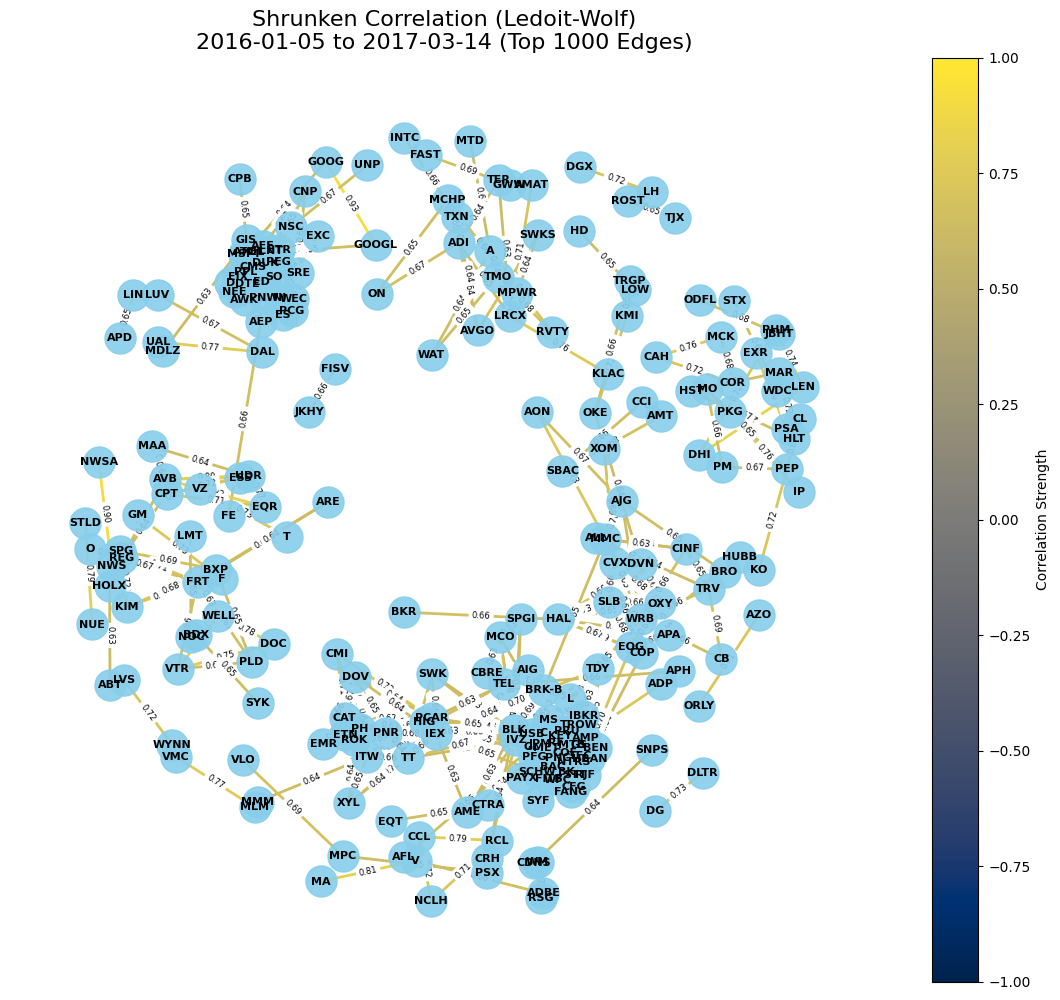

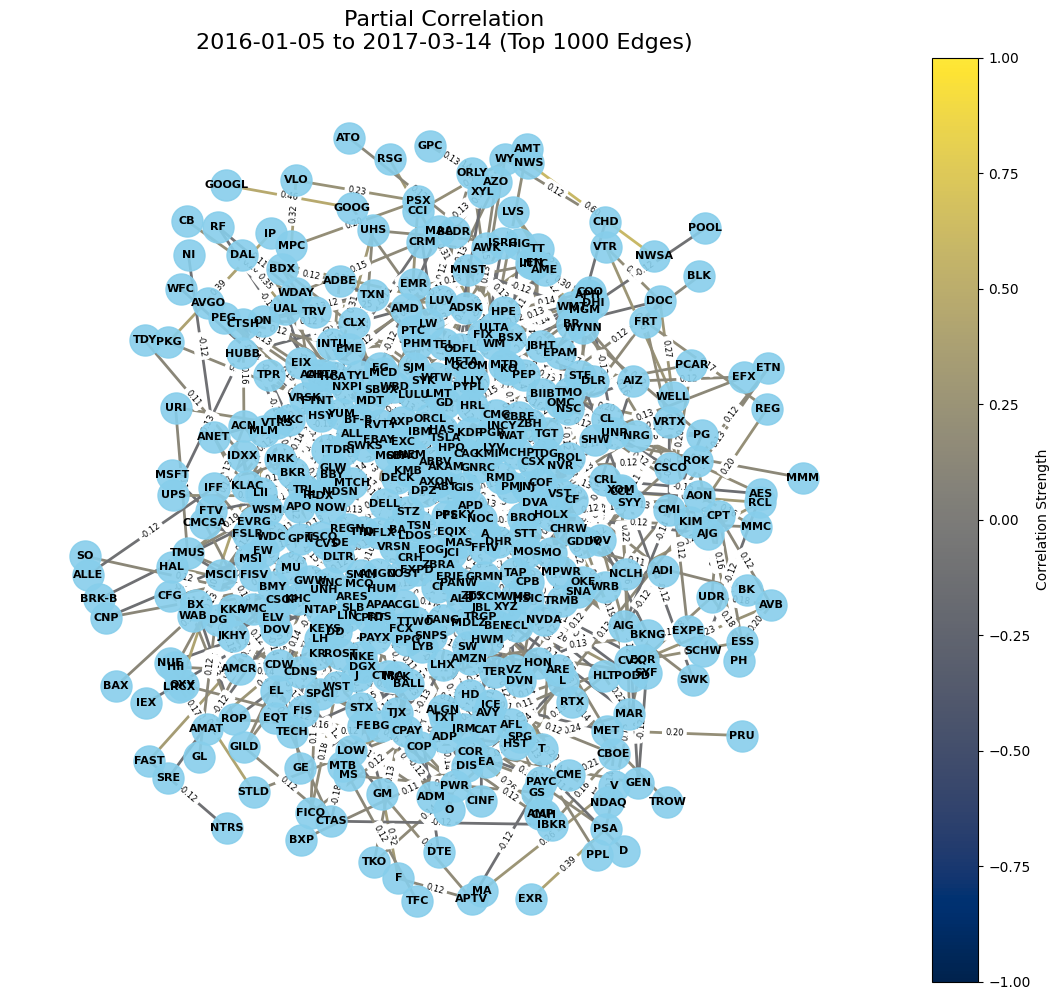

In [4]:
def plot_network(corr_matrix, title, top_n=1000):
    # Mask upper triangle to avoid duplicates and self-loops
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_masked = corr_matrix.where(mask)

    # Flatten to an edge list
    series_corr = corr_masked.stack()
    series_corr.index.names = ['Source', 'Target']
    edges = series_corr.reset_index()
    edges.columns = ['Source', 'Target', 'Weight']

    # Sort by strongest absolute correlations
    edges_sorted = edges.reindex(edges['Weight'].abs().sort_values(ascending=False).index)
    top_edges = edges_sorted.head(top_n)

    # Build Graph
    G = nx.from_pandas_edgelist(top_edges, 'Source', 'Target', ['Weight'])

    # Create a new figure
    plt.figure(figsize=(14, 12))

    # Spring layout tries to cluster highly correlated nodes closer together
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.9)

    # Draw Edges with Spectrum
    weights = [d['Weight'] for (u, v, d) in G.edges(data=True)]

    # Note: vmin/vmax set to -1 and 1 to keep the color scale consistent across plots
    edges_drawn = nx.draw_networkx_edges(
        G, pos,
        width=2,
        edge_color=weights,
        edge_cmap=plt.cm.cividis,
        edge_vmin=-1.0,
        edge_vmax=1.0
    )

    # Draw Node Labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Draw Edge Labels (Weights) - Optional: can comment out if too cluttered
    edge_labels = {(u, v): f"{d['Weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='black')

    plt.title(f"{title} (Top {top_n} Edges)", fontsize=16)
    plt.axis('off')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=plt.Normalize(vmin=-1.0, vmax=1.0))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Correlation Strength')

# Execute Plots

# Get the data from the first window
first_window = network_matrices[0]
date_info = f"{first_window['start_date'].date()} to {first_window['end_date'].date()}"

print(f"Plotting networks for window: {date_info}")

# Standard Pearson
plot_network(first_window['pearson_corr'], f"Standard Pearson Correlation\n{date_info}")

# Shrunken Correlation
plot_network(first_window['shrunk_corr'], f"Shrunken Correlation (Ledoit-Wolf)\n{date_info}")

# Partial Correlation
plot_network(first_window['partial_corr'], f"Partial Correlation\n{date_info}")

plt.show()

## Step 4: Local Mispricings using Laplacian Diffusion

Based on https://doi.org/10.1007/s10114-004-0437-9 and https://doi.org/10.1137/1.9781611972801.

In [7]:
# Estimate residuals using the Signed Laplacian Diffusion (Heat Kernel)
def calculate_signed_diffusion_residuals(log_returns, adj_matrix, tau=0.5):
    """
    Args:
        log_returns (pd.Series): The vector of returns for one day.
        adj_matrix (pd.DataFrame): The Partial Correlation Matrix (A).
        tau (float): Diffusion time.
                     - Small tau (0.1) = weak smoothing (residuals ~ 0).
                     - Large tau (1.0+) = strong smoothing (residuals dominate).

    Returns:
        pd.Series: The residuals (Actual - Diffused Expected).
    """
    # Align Data
    valid_tickers = adj_matrix.index.intersection(log_returns.index)
    s_actual = log_returns[valid_tickers].values
    A = adj_matrix.loc[valid_tickers, valid_tickers].values

    # Construct Signed Laplacian (Ls = D_abs - A)
    degrees_abs = np.sum(np.abs(A), axis=1)
    D_abs = np.diag(degrees_abs)
    Ls = D_abs - A

    # Compute Heat Kernel: e^(-tau * Ls)
    kernel = expm(-tau * Ls)

    # Diffuse
    s_expected = kernel @ s_actual

    # Calculate Residual
    residuals = s_actual - s_expected

    return pd.Series(residuals, index=valid_tickers)

# List Mispricings
last_window = network_matrices[-1]
last_day_returns = log_returns.iloc[-1]

# Standard Pearson
pearson_corr = last_window['pearson_corr']
pearson_res = calculate_signed_diffusion_residuals(last_day_returns, pearson_corr, tau=0.5)

print("--- Short Candidates (Standard Pearson Correlation) ---")
print(pearson_res[pearson_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Standard Pearson Correlation) ---")
print(pearson_res[pearson_res < 0].sort_values().head(5))

# Shrunken Correlation
shrunk_corr = last_window['shrunk_corr']
shrunk_res = calculate_signed_diffusion_residuals(last_day_returns, shrunk_corr, tau=0.5)

print("\n--- Short Candidates (Shrunken Correlation) ---")
print(shrunk_res[shrunk_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Shrunken Correlation) ---")
print(shrunk_res[shrunk_res < 0].sort_values().head(5))

# Partial Correlation
partial_corr = last_window['partial_corr']
partial_res = calculate_signed_diffusion_residuals(last_day_returns, partial_corr, tau=0.5)

print("\n--- Short Candidates (Partial Correlation) ---")
print(partial_res[partial_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Partial Correlation) ---")
print(partial_res[partial_res < 0].sort_values().head(5))

--- Short Candidates (Standard Pearson Correlation) ---
Ticker
MU      0.098152
WDC     0.083959
LRCX    0.076107
FIX     0.070934
TER     0.068019
dtype: float64

--- Long Candidates (Standard Pearson Correlation) ---
Ticker
IT     -0.064308
INTU   -0.052978
ADBE   -0.050808
GDDY   -0.047800
PAYC   -0.046600
dtype: float64

--- Short Candidates (Shrunken Correlation) ---
Ticker
MU      0.097908
WDC     0.083716
LRCX    0.075859
FIX     0.070702
TER     0.067777
dtype: float64

--- Long Candidates (Shrunken Correlation) ---
Ticker
IT     -0.064568
INTU   -0.053237
ADBE   -0.051068
GDDY   -0.048060
PAYC   -0.046859
dtype: float64

--- Short Candidates (Partial Correlation) ---
Ticker
MU      0.099592
WDC     0.085357
LRCX    0.076942
FIX     0.072153
TER     0.069650
dtype: float64

--- Long Candidates (Partial Correlation) ---
Ticker
IT     -0.062222
INTU   -0.050957
ADBE   -0.048780
GDDY   -0.045748
PAYC   -0.044548
dtype: float64


In [12]:
add this:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure your diffusion function is defined (from your previous script)
# def calculate_signed_diffusion_residuals(log_returns, adj_matrix, tau=0.5): ...

def view_market_physics(window_index, tau):
    """
    Interactive handler to visualize market anomalies.
    """
    # 1. Retrieve Data for the Selected Window
    # window_index lets you time-travel back to 2016, 2020, etc.
    window_data = network_matrices[window_index]
    partial_corr = window_data['partial_corr']

    # Get the returns for the LAST day of that specific window
    end_date = window_data['end_date']
    try:
        # We need the specific return vector aligned with this matrix
        day_returns = log_returns.loc[end_date]
    except KeyError:
        print(f"Return data not found for {end_date}")
        return

    # 2. Run the Physics Engine
    # This runs your Signed Laplacian function in real-time
    residuals = calculate_signed_diffusion_residuals(day_returns, partial_corr, tau=tau)

    # 3. Display the Dashboard
    print(f"📅 Date: {end_date.date()}")
    print(f"📉 Market Regime: {'High Correlation' if window_data['shrinkage_coeff'] > 0.5 else 'Normal'}")
    print(f"⏱️ Diffusion Tau: {tau} (Smoothing Strength)\n")

    # Format and Print Top Candidates
    shorts = residuals[residuals > 0].sort_values(ascending=False).head(5)
    longs = residuals[residuals < 0].sort_values().head(5)

    # Create a simple text table
    print(f"{'SHORT CANDIDATES (Overextended)':<40} | {'LONG CANDIDATES (Lagging)':<40}")
    print("-" * 85)

    for i in range(5):
        # Handle cases where we have fewer than 5 results
        s_str = f"{shorts.index[i]}: {shorts.iloc[i]:.5f}" if i < len(shorts) else ""
        l_str = f"{longs.index[i]}: {longs.iloc[i]:.5f}" if i < len(longs) else ""
        print(f"{s_str:<40} | {l_str:<40}")

# --- Create the Sliders ---

# Slider for History (0 to End)
idx_slider = widgets.IntSlider(
    value=len(network_matrices)-1,
    min=0,
    max=len(network_matrices)-1,
    step=1,
    description='Window Idx:',
    continuous_update=False  # Only calculate when you release the mouse
)

# Slider for Tau (0.1 to 2.0)
tau_slider = widgets.FloatSlider(
    value=0.5,
    min=0.05,
    max=2.0,
    step=0.05,
    description='Tau (Diff):',
    continuous_update=False
)

# Render the UI
ui = widgets.interact(view_market_physics, window_index=idx_slider, tau=tau_slider);

SyntaxError: invalid syntax (ipython-input-2716902046.py, line 1)